### First set number of cores on machine to use and SSID number to analyse, then run all

In [1]:
# setting variables

cores = 3 # enter the number of cores to use here, in place of x
SSIDno = 13551357 # enter the SSID number to model as an int here, in place of xxxxxxxx

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
#import matplotlib.patches as mpatches
#import matplotlib.font_manager as fm
import matplotlib
import autotime
%matplotlib inline
%load_ext autotime
#import seaborn as sns
import statsmodels as stm
import statsmodels.formula.api as sm
from sklearn.feature_selection import VarianceThreshold
from sklearn import metrics
from sklearn.linear_model import LinearRegression as LinR
from sklearn.svm import SVR
from sklearn.ensemble import GradientBoostingRegressor as GBR
from sklearn.ensemble import RandomForestRegressor as RFR
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV as RSCV
# from dask_searchcv import RandomizedSearchCV as DRSCV
# from sklearn.pipeline import Pipeline
from sklearn.metrics.scorer import make_scorer
# from sklearn.preprocessing import MinMaxScaler as MMS
from scipy import stats
from scipy.stats import randint

#from sklearn.tree import export_graphviz
#from IPython.display import Image

## 1. Data processing stage

First, select route files to input based on SSIDno to analyse

### 1a Inputting data and creating dataframe for SSIDno

In [3]:
# Read in stop_times.txt and trips.txt files from NTA data
stop_times_2012 = pd.read_csv('stop_times.txt')
trips_2012 = pd.read_csv('trips.txt')

# Merge by trip_id
merge = pd.merge(stop_times_2012, trips_2012, on='trip_id', how='outer')

# Keep only necessary columns
merge.drop(['arrival_time','departure_time','pickup_type','drop_off_type','service_id','shape_dist_traveled'], axis=1, inplace=True)

# Transform trip_id to route and stop_id to StopID
merge['route_short'] = merge['trip_id'].apply(lambda x: x[x.index('-')+1:])
merge['route_short'] = merge['route_short'].apply(lambda x: x[: x.index('-')])
merge['route_short'] = merge['route_short'].apply(lambda x: str(x).zfill(4))
merge['StopID'] = merge['stop_id'].apply(lambda x: x[-4:])

# Find StopID and the sequence of that shape_id
gb = merge.groupby(['shape_id', 'route_short', 'direction_id','stop_sequence', 'StopID'])
gbc = gb.count()
gbc.reset_index(['shape_id', 'route_short', 'direction_id','stop_sequence', 'StopID'], inplace=True)
transit_shapeID_stopID = gbc.drop(['trip_id','stop_id','route_id','trip_headsign'], axis=1)

# create list of pairs of routes and the SSIDs contained within them
ssid = []
for i in range(len(transit_shapeID_stopID.index)-1):
    temp = transit_shapeID_stopID['StopID'].iloc[i] + transit_shapeID_stopID['StopID'].iloc[i+1]
    ssid.append([ transit_shapeID_stopID['route_short'].iloc[i],temp])
    
SSIDnoStr = str(SSIDno).zfill(8)
routes = [x for x in ssid if SSIDnoStr in x[1]]
routes = [item[0] for item in routes]
routes = list(set(routes))

# Reading in the route CSV files for the required SSID

res = pd.read_csv('Route_XXXX_travel_time_csvs/Blank_Route_travel_time.csv')
route_list = routes
for r in route_list:
    df = pd.read_csv('Route_XXXX_travel_time_csvs/Route_%s_travel_time.csv' % r)
    res = pd.concat([df, res], axis=0) 

time: 7.65 s


In [4]:
# create dataframe for SSIDno

res['SSID'] = res['SSID'].astype('category')
ssid_df = res[res.SSID == SSIDno]
ssid_df.reset_index(inplace=True)
ssid_df = ssid_df.drop('index', axis=1)
ssid_df.shape

(16093, 12)

time: 212 ms


In [5]:
ssid_df.memory_usage(deep=True)

Index                    80
Day                 1033744
DestStopID           128744
HourFrame            128744
JourneyPatternID     635666
Rain                 128744
SSID                 236170
SchoolHoliday         16093
SourceStopID         128744
TimeFrame           1078231
TravelTime           128744
VehicleJourneyID     128744
WindSpeed            128744
dtype: int64

time: 10 ms


In [6]:
JPID_Count = ssid_df.JourneyPatternID.unique()
Row_Count = ssid_df.shape[0]
print("There are", JPID_Count, "unique JPIDs traversing this segment, over the course of", Row_Count, "observations.")

There are [91001 91002 '068A1001' 1221001 1221002 831001 831003 831004 161001
 '016C1001' '065B1001' '083A1001' '083A1002' 681001 681002 681003 681004
 651001 651002 651003] unique JPIDs traversing this segment, over the course of 16093 observations.
time: 3 ms


In [7]:
# add leading zeroes to JourneyPatternID

ssid_df.JourneyPatternID = ssid_df.JourneyPatternID.astype('object')
ssid_df.JourneyPatternID = ssid_df.JourneyPatternID.apply(lambda x: str(x).zfill(8))

time: 12 ms


### 1b Adding extra features and altering/dropping existing ones

In [8]:
# adding Xbuses feature - boolean feature indicating whether or not the JourneyPatternID represents an express (X) bus

ssid_df['XBuses'] = ssid_df[ssid_df["JourneyPatternID"].str.find("X") > 0].sum(axis=1) > 0
ssid_df["XBuses"].fillna(False, inplace=True)
ssid_df['XBuses'] = ssid_df['XBuses'].astype('int')

time: 15 ms


In [9]:
# adding JPID_length feature - represents the total number of stops traversed by this JourneyPatternID along its entire route

JPIDL = pd.read_csv('JPID_Length.csv')
JPIDL = JPIDL.drop('Unnamed: 0', axis=1)
ssid_df = pd.merge(left=ssid_df ,right=JPIDL, how='left', left_on='JourneyPatternID', right_on='JourneyPatternID')
ssid_df = ssid_df.dropna()
ssid_df.shape

(16093, 14)

time: 27 ms


In [10]:
# NOTE: feature currently not being used due to issues with inputting it to the model

# adding JPID_Freq feature - represents how often in the given data this JourneyPatternID traversed this segment

# ssid_df['JPID_Freq'] = ssid_df.groupby(['JourneyPatternID'])['JourneyPatternID'].transform('count')

time: 1e+03 µs


In [11]:
# removing non-holiday-period weekends from SchoolHoliday feature to avoid multi-collinearity issues

ssid_df['SchoolHoliday'] = ssid_df['SchoolHoliday'].astype('int')
ssid_df['SchoolHoliday'] = np.where(ssid_df['TimeFrame'].isin(['2013-01-01', '2013-01-02', '2013-01-03', '2013-01-04', '2013-01-05', '2013-01-06']), 1, 0)

time: 3 ms


In [12]:
# fetching SSID number from dataframe for CSV file naming purposes

res.SSID = res.SSID.apply(lambda x: str(int(x)).zfill(8))
r = ssid_df.loc[0, 'SSID'] 

time: 20 ms


In [13]:
# dropping unneeded columns

ssid_df = ssid_df.drop(['SourceStopID', 'DestStopID', 'VehicleJourneyID', 'JourneyPatternID', 'SSID'], axis=1)

# reordering remaining columns

ssid_df = ssid_df[['TravelTime', 'Rain', 'WindSpeed', 'JPID_length', 'XBuses', 'SchoolHoliday', 'Day', 'HourFrame']]

time: 6 ms


In [14]:
ssid_df

,TravelTime,Rain,WindSpeed,JPID_length,XBuses,SchoolHoliday,Day,HourFrame
0,59,0.000000,12.0,68,0,0,Tuesday,6
1,59,0.000000,15.5,68,0,0,Tuesday,9
2,80,0.000000,17.5,68,0,0,Tuesday,12
3,99,0.033325,14.5,68,0,0,Tuesday,7
4,117,0.000000,16.5,68,0,0,Tuesday,10
5,57,0.033325,14.5,68,0,0,Tuesday,7
6,98,0.000000,16.5,68,0,0,Tuesday,10
7,61,0.000000,15.0,68,0,0,Tuesday,8
8,39,0.000000,17.5,68,0,0,Tuesday,11
9,118,0.000000,17.0,68,0,0,Tuesday,14


time: 27 ms


In [15]:
# assigning appropriate datatypes where necessary

ssid_df['Day'] = ssid_df['Day'].astype('category')
ssid_df['HourFrame'] = ssid_df['HourFrame'].astype('category')
ssid_df['JPID_length'] = ssid_df['JPID_length'].astype('int')

time: 33 ms


In [16]:
# removing any constant features
# code from: https://stackoverflow.com/questions/20209600/panda-dataframe-remove-constant-column

ssid_df = ssid_df.loc[:,ssid_df.apply(pd.Series.nunique) != 1]

time: 11 ms


In [17]:
ssid_df

,TravelTime,Rain,WindSpeed,JPID_length,SchoolHoliday,Day,HourFrame
0,59,0.000000,12.0,68,0,Tuesday,6
1,59,0.000000,15.5,68,0,Tuesday,9
2,80,0.000000,17.5,68,0,Tuesday,12
3,99,0.033325,14.5,68,0,Tuesday,7
4,117,0.000000,16.5,68,0,Tuesday,10
5,57,0.033325,14.5,68,0,Tuesday,7
6,98,0.000000,16.5,68,0,Tuesday,10
7,61,0.000000,15.0,68,0,Tuesday,8
8,39,0.000000,17.5,68,0,Tuesday,11
9,118,0.000000,17.0,68,0,Tuesday,14


time: 27 ms


In [18]:
# save as csv

ssid_df.to_csv('SSID_CSVs/SSID_%s.csv' % r)

time: 97 ms


## 1c. Dropping Outliers

#### Visualising range of travel-time data first

Histiogram of values (x-axis is number of seconds)

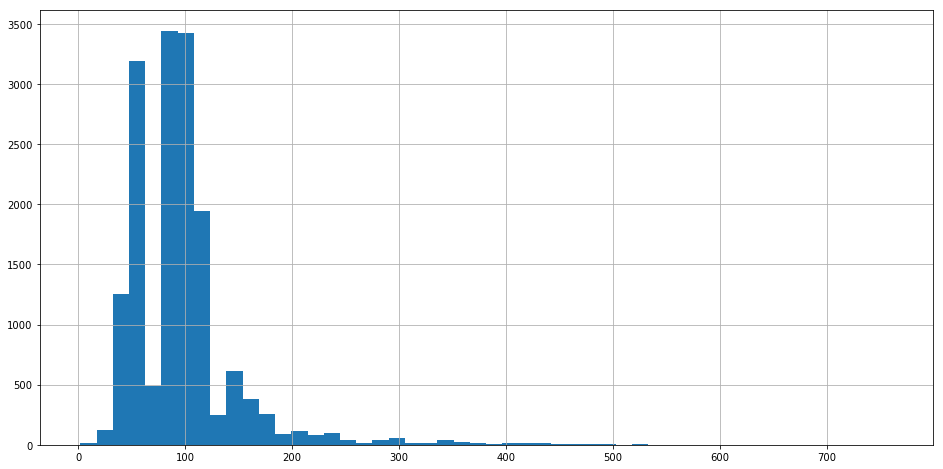

time: 225 ms


In [19]:
ssid_df.TravelTime.hist(figsize=(16, 8), bins=50)

Boxplot to check for outliers

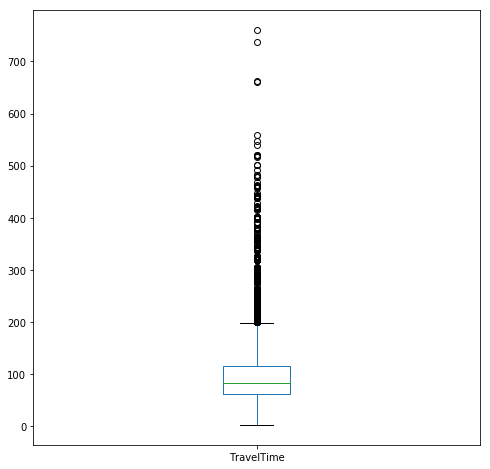

time: 204 ms


In [20]:
ssid_df.TravelTime.plot(kind='box', figsize=(8, 8), showfliers=True)

In [21]:
# Checking stats for TravelTime

ssid_df.TravelTime.describe()

count    16093.000000
mean        96.409930
std         51.760333
min          2.000000
25%         61.000000
50%         82.000000
75%        116.000000
max        761.000000
Name: TravelTime, dtype: float64

time: 7 ms


Dropping outliers

In [22]:
# loading table of minimum times to traverse segments at 65kmph

find_lb = pd.read_csv('use_speed_and_distance_get_outlier_bound.csv')

# extracting value for this segment, to use as lower bound for outlier removal

lb = find_lb.loc[find_lb['SSID'] == SSIDno, 'min_sec'].iloc[0]
print(lb)

16.2024070247
time: 10 ms


In [23]:
# make a copy of original df

trimssid_df = ssid_df.copy()

# Remove TravelTime upper bound outliers beyond a conservative 3 x IQR, and lowerbound below 'lb'

ub = trimssid_df.quantile(q=.75) + (3*(trimssid_df.quantile(q=.75)-trimssid_df.quantile(q=.25)))
trimssid_df['OutlierTT'] = (trimssid_df['TravelTime'] < lb) | (trimssid_df['TravelTime'] > ub['TravelTime'])

# Outlier rows counted

print("There will be", trimssid_df[(trimssid_df['OutlierTT'] == True)].shape[0], "outliers dropped.")

There will be 255 outliers dropped.
time: 17 ms


In [24]:
# dropping outliers

trimssid_df = trimssid_df[trimssid_df.OutlierTT != True]
trimssid_df.sort_values(['TravelTime'], ascending=False, inplace=True)
trimssid_df = trimssid_df.drop(['OutlierTT'], axis=1)
trimssid_df.reset_index(inplace=True)
trimssid_df = trimssid_df.drop('index', axis=1)
trimssid_df

,TravelTime,Rain,WindSpeed,JPID_length,SchoolHoliday,Day,HourFrame
0,281,0.000000,8.5,88,0,Friday,20
1,281,0.033325,7.0,68,0,Friday,21
2,281,0.000000,8.0,68,0,Friday,18
3,281,0.000000,10.5,70,0,Saturday,20
4,281,0.033333,14.5,86,0,Tuesday,21
5,281,0.000000,8.5,72,1,Sunday,19
6,280,3.600000,6.5,68,0,Friday,19
7,280,0.600000,11.0,72,0,Friday,23
8,280,0.033325,11.0,68,0,Friday,18
9,280,0.000000,8.0,70,0,Friday,21


time: 64 ms


In [25]:
# Create TT mean/median value variables, to use in calculating mean/median absolute percentage accuracy scores
# and for horizontal lines in the charts below to represent the mean/medium

ssid_df = trimssid_df
ssid_df_mean = ssid_df.TravelTime.mean()
ssid_df_median  = ssid_df.TravelTime.median()
ssid_df.TravelTime.describe()

count    15838.000000
mean        92.341457
std         38.923850
min         17.000000
25%         61.000000
50%         82.000000
75%        106.000000
max        281.000000
Name: TravelTime, dtype: float64

time: 7 ms


#### Visualising range of data after dropping outliers

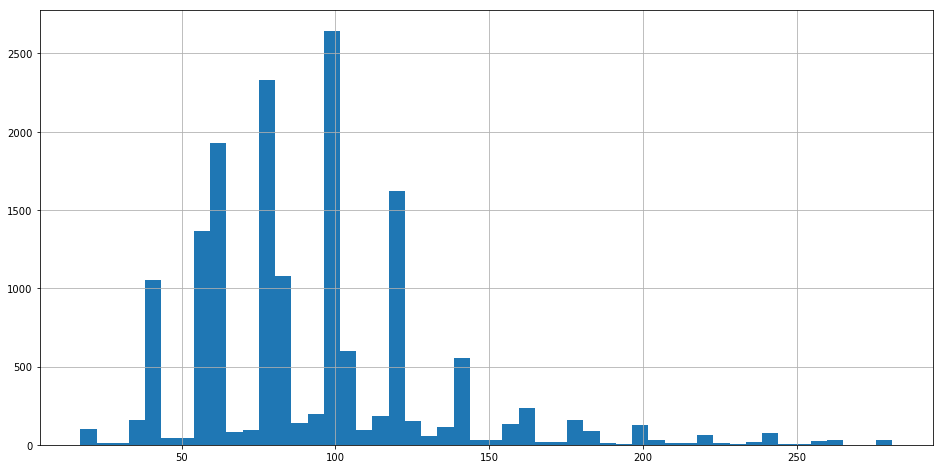

time: 207 ms


In [26]:
ssid_df.TravelTime.hist(figsize=(16, 8), bins=50)

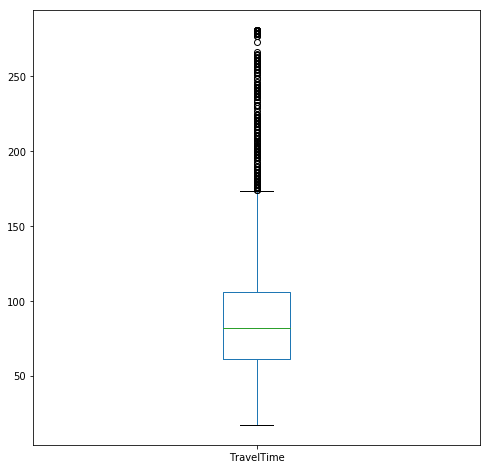

time: 200 ms


In [27]:
ssid_df.TravelTime.plot(kind='box', figsize=(8, 8), showfliers=True)

## 2. Visualising the data

### 2ai Bar plot for mean TravelTime per HourFrame

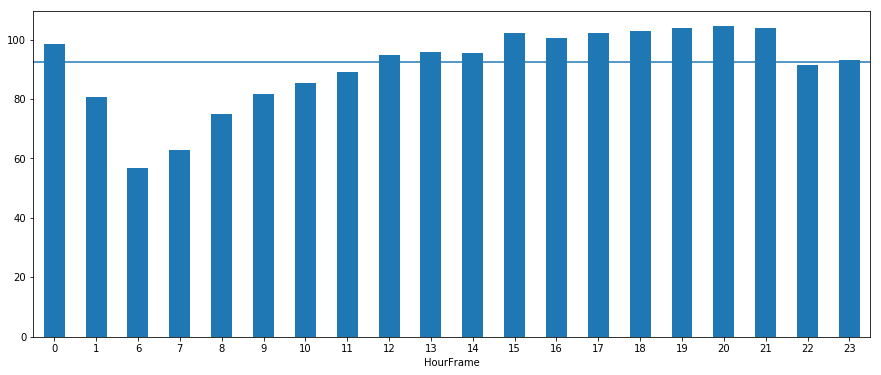

time: 192 ms


In [28]:
mean_HF = ssid_df.groupby('HourFrame')['TravelTime'].mean()
mean_HF.plot(kind='bar', figsize=(15, 6), rot=0)

coord_x1 = -1
coord_y1 = ssid_df_mean
coord_x2 = 25

plt.plot([coord_x1, coord_x2], [coord_y1, coord_y1], '-o')

Observation:  

### 2aii Bar plot for median TravelTime per HourFrame

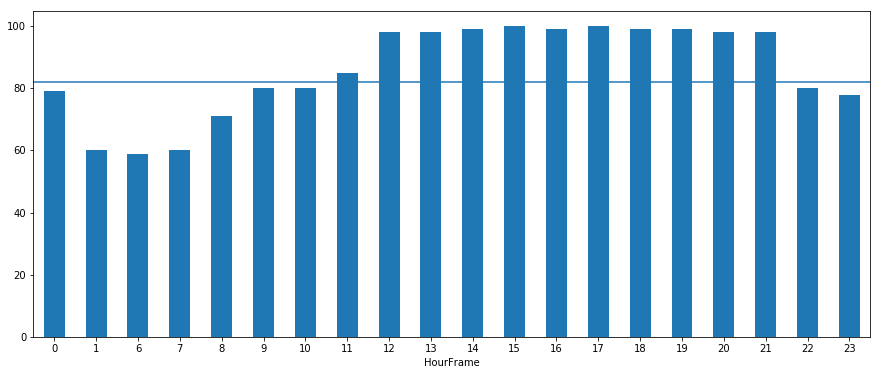

time: 191 ms


In [29]:
med_HF = ssid_df.groupby('HourFrame')['TravelTime'].median()
med_HF.plot(kind='bar', figsize=(15, 6), rot=0)

coord_x1 = -1
coord_y1 = ssid_df_median
coord_x2 = 25

plt.plot([coord_x1, coord_x2], [coord_y1, coord_y1], '-o')

Observation:  

### 2bi Bar plot for mean TravelTime per Day

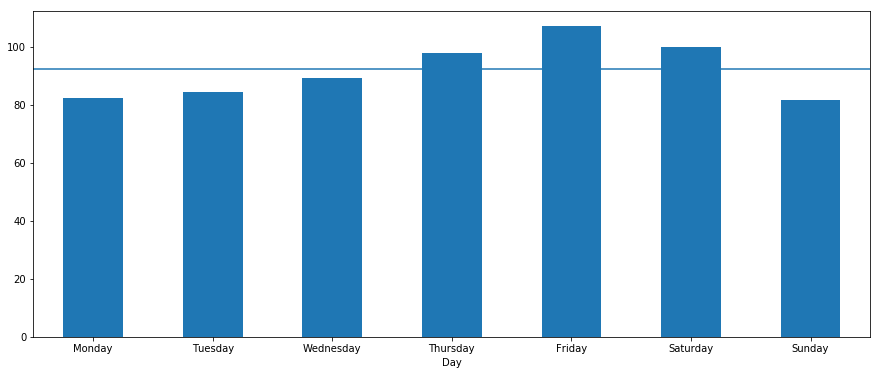

time: 148 ms


In [30]:
mean_Day = ssid_df.groupby('Day')['TravelTime'].mean()
mean_Day=mean_Day.reindex(['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'])

mean_Day.plot(kind='bar', figsize=(15, 6), rot=0)

coord_x1 = -1
coord_y1 = ssid_df_mean

coord_x2 = 7

plt.plot([coord_x1, coord_x2], [coord_y1, coord_y1], '-o')

Observation:  

### 2bii Bar plot for median TravelTime per HourFrame

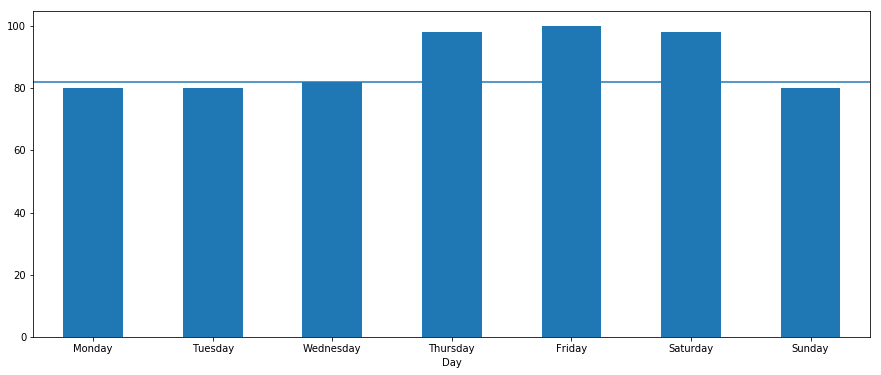

time: 145 ms


In [31]:
med_Day = ssid_df.groupby('Day')['TravelTime'].median()

med_Day=med_Day.reindex(['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'])
med_Day.plot(kind='bar', figsize=(15, 6), rot=0)

coord_x1 = -1
coord_y1 = ssid_df_median
coord_x2 = 7

plt.plot([coord_x1, coord_x2], [coord_y1, coord_y1], '-o')

Observation: 

### 2ci Bar plot for mean TravelTime when SchoolHoliday true/false

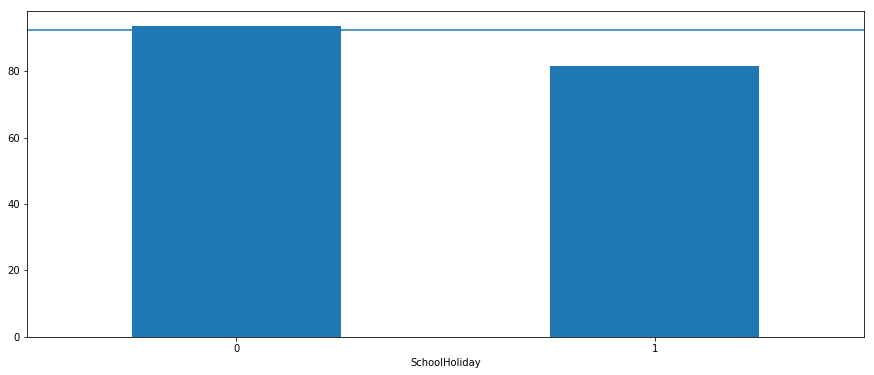

time: 161 ms


In [32]:
mean_SH = ssid_df.groupby('SchoolHoliday')['TravelTime'].mean()
mean_SH.plot(kind='bar', figsize=(15, 6), rot=0)

coord_x1 = -1
coord_y1 = ssid_df_mean
coord_x2 = 7

plt.plot([coord_x1, coord_x2], [coord_y1, coord_y1], '-o')

Observation:  

### 2cii Bar plot for median TravelTime when SchoolHoliday true/false

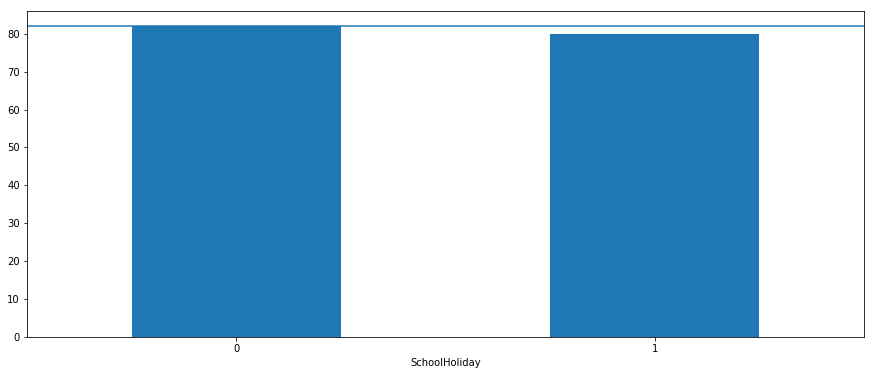

time: 132 ms


In [33]:
med_SH = ssid_df.groupby('SchoolHoliday')['TravelTime'].median()
med_SH.plot(kind='bar', figsize=(15, 6), rot=0)

coord_x1 = -1
coord_y1 = ssid_df_median
coord_x2 = 7

plt.plot([coord_x1, coord_x2], [coord_y1, coord_y1], '-o')

Splitting data into 70% for training and 30% for testing

## 3 Model training (Scikit-learn)

First we need to dreate dummy variables for categorical features, and split into test and training sets

### 3.1 Prepare data for modelling via Scikit-learn

In [34]:
# create dummy variables from HourFrame and Day using get_dummies
# dropping first values to avoid multicollinearity (Day = Friday, Hour = 0 or 6 or 7, depending on SSID)

Day_dummies = pd.get_dummies(ssid_df.Day, prefix='Day', drop_first=True)
HF_dummies = pd.get_dummies(ssid_df.HourFrame, prefix='HF', drop_first=True)

# concatenate the dummy variable columns onto the original DataFrame and drop the original features
ssid_df = pd.concat([ssid_df, HF_dummies, Day_dummies], axis=1)
ssid_df = ssid_df.drop(['HourFrame', 'Day'], axis=1)
ssid_df

,TravelTime,Rain,WindSpeed,JPID_length,SchoolHoliday,HF_1,HF_6,HF_7,HF_8,HF_9,...,HF_20,HF_21,HF_22,HF_23,Day_Monday,Day_Saturday,Day_Sunday,Day_Thursday,Day_Tuesday,Day_Wednesday
0,281,0.000000,8.5,88,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
1,281,0.033325,7.0,68,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
2,281,0.000000,8.0,68,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,281,0.000000,10.5,70,0,0,0,0,0,0,...,1,0,0,0,0,1,0,0,0,0
4,281,0.033333,14.5,86,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,1,0
5,281,0.000000,8.5,72,1,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
6,280,3.600000,6.5,68,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
7,280,0.600000,11.0,72,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
8,280,0.033325,11.0,68,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9,280,0.000000,8.0,70,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0


time: 59 ms


In [35]:
# prepare a list containing all remaining features bar the target
pred_features = list(ssid_df)
pred_features.remove('TravelTime')
print(pred_features)

['Rain', 'WindSpeed', 'JPID_length', 'SchoolHoliday', 'HF_1', 'HF_6', 'HF_7', 'HF_8', 'HF_9', 'HF_10', 'HF_11', 'HF_12', 'HF_13', 'HF_14', 'HF_15', 'HF_16', 'HF_17', 'HF_18', 'HF_19', 'HF_20', 'HF_21', 'HF_22', 'HF_23', 'Day_Monday', 'Day_Saturday', 'Day_Sunday', 'Day_Thursday', 'Day_Tuesday', 'Day_Wednesday']
time: 1e+03 µs


In [36]:
# prepare target/predictive feature variables for use in scikit-learn modelling

X = ssid_df[pred_features]
y = ssid_df['TravelTime']

time: 5 ms


In [37]:
# split the data into training portion (70%) and final testing potion (30%)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 38)

time: 4 ms


### 3bi Linear Regression model (via scikit-learn) - training - default parameters

In [38]:
lr = LinR(n_jobs = cores)
lr.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=3, normalize=False)

time: 77 ms


In [39]:
lr_pred = lr.predict(X_train)
lr_rsq = metrics.r2_score(y_train, lr_pred)
print ("The R-squared value of the Linear Regression model is", lr_rsq)

The R-squared value of the Linear Regression model is 0.179188662999
time: 43 ms


In [40]:
lr_mae = metrics.mean_absolute_error(y_train, lr_pred)
print ("The mean absolute error of the Linear Regression model is", lr_mae)
print ("The mean absolute percentage error is", (((lr_mae)/ssid_df_mean)*100))

The mean absolute error of the Linear Regression model is 26.2258568158
The mean absolute percentage error is 28.4009561853
time: 2 ms


In [41]:
lr_mdae = metrics.median_absolute_error(y_train, lr_pred)
print ("The median absolute error of the Linear Regression model is", lr_mdae)
print ("The median absolute percentage error is", (((lr_mdae)/ssid_df_median)*100))

The median absolute error of the Linear Regression model is 20.9420110386
The median absolute percentage error is 25.539037852
time: 3 ms


### 3bii Linear Regression model (via scikit-learn) - testing - default parameters

In [42]:
lr_preda = lr.predict(X_test)
lr_rsqa = metrics.r2_score(y_test, lr_preda)
print ("The R-squared value of the Linear Regression model is", lr_rsqa)

The R-squared value of the Linear Regression model is 0.171459249099
time: 27 ms


In [43]:
lr_maea = metrics.mean_absolute_error(y_test, lr_preda)
print ("The mean absolute error of the Linear Regression model is", lr_maea)
print ("The mean absolute percentage error is", (((lr_maea)/ssid_df_mean)*100))

The mean absolute error of the Linear Regression model is 26.7036942654
The mean absolute percentage error is 28.9184241394
time: 2 ms


In [44]:
lr_mdaea = metrics.median_absolute_error(y_test, lr_preda)
print ("The median absolute error of the Linear Regression model is", lr_mdaea)
print ("The median absolute percentage error is", (((lr_mdaea)/ssid_df_median)*100))

The median absolute error of the Linear Regression model is 21.4978692773
The median absolute percentage error is 26.2169137529
time: 3 ms


### 3ci Support Vector Machine Regression with RBF Kernel model - training - default parameters

In [45]:
svr_rbf = SVR(kernel='rbf')
svr_rbf.fit(X_train, y_train)

SVR(C=1.0, cache_size=200, coef0=0.0, degree=3, epsilon=0.1, gamma='auto',
  kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False)

time: 6.81 s


In [46]:
svr_rbf_pred = svr_rbf.predict(X_train)
svr_rbf_rsq = metrics.r2_score(y_train, svr_rbf_pred)
print ("The R-squared value of the SVR with RBF Kernel model is", svr_rbf_rsq)

The R-squared value of the SVR with RBF Kernel model is 0.0477327392651
time: 4.6 s


In [47]:
svr_rbf_mae = metrics.mean_absolute_error(y_train, svr_rbf_pred)
print ("The mean absolute error of the SVR with RBF Kernel model is", svr_rbf_mae)
print ("The mean absolute percentage error is", (((svr_rbf_mae)/ssid_df_mean)*100))

The mean absolute error of the SVR with RBF Kernel model is 27.1085973249
The mean absolute percentage error is 29.3569087285
time: 3 ms


In [48]:
svr_rbf_mdae = metrics.median_absolute_error(y_train, svr_rbf_pred)
print ("The median absolute error of the SVR with RBF Kernel model is", svr_rbf_mdae)
print ("The median absolute percentage error is", (((svr_rbf_mdae)/ssid_df_median)*100))

The median absolute error of the SVR with RBF Kernel model is 20.8666366002
The median absolute percentage error is 25.4471178051
time: 3 ms


### 3cii Support Vector Machine Regression with RBF Kernel model - testing - default parameters

In [49]:
svr_rbf_preda = svr_rbf.predict(X_test)
svr_rbf_rsqa = metrics.r2_score(y_test, svr_rbf_preda)
print ("The R-squared value of the SVR with RBF Kernel model is", svr_rbf_rsqa)

The R-squared value of the SVR with RBF Kernel model is 0.0412426669795
time: 1.98 s


In [50]:
svr_rbf_maea = metrics.mean_absolute_error(y_test, svr_rbf_preda)
print ("The mean absolute error of the SVR with RBF Kernel model is", svr_rbf_maea)
print ("The mean absolute percentage error is", (((svr_rbf_maea)/ssid_df_mean)*100))

The mean absolute error of the SVR with RBF Kernel model is 27.4725702792
The mean absolute percentage error is 29.7510685839
time: 2 ms


In [51]:
svr_rbf_mdaea = metrics.median_absolute_error(y_test, svr_rbf_preda)
print ("The median absolute error of the SVR with RBF Kernel model is", svr_rbf_mdaea)
print ("The median absolute percentage error is", (((svr_rbf_mdaea)/ssid_df_median)*100))

The median absolute error of the SVR with RBF Kernel model is 21.5054075921
The median absolute percentage error is 26.2261068196
time: 4 ms


### 3di Gradient Boosting Regression model - training - default parameters

In [52]:
gbr = GBR()
gbr.fit(X_train, y_train)

GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.1, loss='ls', max_depth=3, max_features=None,
             max_leaf_nodes=None, min_impurity_split=1e-07,
             min_samples_leaf=1, min_samples_split=2,
             min_weight_fraction_leaf=0.0, n_estimators=100,
             presort='auto', random_state=None, subsample=1.0, verbose=0,
             warm_start=False)

time: 552 ms


In [53]:
indices = np.argsort(gbr.feature_importances_)[::-1]

# Print the ordered feature ranking
print("Ordered feature ranking:")

for f in range(X_train.shape[1]):
    feat = indices[f]
    print(X_train.columns[feat], "\t", gbr.feature_importances_[indices[f]])

Ordered feature ranking:
WindSpeed 	 0.0919436321399
Day_Monday 	 0.0788434915095
Rain 	 0.0762081168573
HF_7 	 0.0704427675736
Day_Sunday 	 0.0694050969685
Day_Saturday 	 0.0625290988543
JPID_length 	 0.0584008073144
Day_Tuesday 	 0.0556820457662
HF_23 	 0.0515764417486
HF_8 	 0.0453055445075
HF_9 	 0.0403932334914
SchoolHoliday 	 0.0403448625414
HF_6 	 0.0403115341054
Day_Wednesday 	 0.0328477785772
HF_10 	 0.0276530643864
HF_20 	 0.0245966575541
HF_21 	 0.0244441798792
HF_22 	 0.0187524927441
HF_11 	 0.0177229531065
HF_18 	 0.0146651702452
HF_15 	 0.0126550202882
Day_Thursday 	 0.0123293984431
HF_19 	 0.00978083011409
HF_17 	 0.00919932291741
HF_16 	 0.00857735308246
HF_14 	 0.00317901346985
HF_13 	 0.00221009181404
HF_12 	 0.0
HF_1 	 0.0
time: 74 ms


In [54]:
gbr_pred = gbr.predict(X_train)
gbr_rsq = metrics.r2_score(y_train, gbr_pred)
print ("The R-squared value of the Gradient Boosting Regression model is", gbr_rsq)

The R-squared value of the Gradient Boosting Regression model is 0.241857518745
time: 18 ms


In [55]:
gbr_mae = metrics.mean_absolute_error(y_train, gbr_pred)
print ("The mean absolute error of the Gradient Boosting Regression model is", gbr_mae)
print ("The mean absolute percentage error is", (((gbr_mae)/ssid_df_mean)*100))

The mean absolute error of the Gradient Boosting Regression model is 25.0787480751
The mean absolute percentage error is 27.1587094472
time: 3 ms


In [56]:
gbr_mdae = metrics.median_absolute_error(y_train, gbr_pred)
print ("The median absolute error of the Gradient Boosting Regression model is", gbr_mdae)
print ("The median absolute percentage error is", (((gbr_mdae)/ssid_df_median)*100))

The median absolute error of the Gradient Boosting Regression model is 20.2104272857
The median absolute percentage error is 24.6468625435
time: 9 ms


### 3dii Gradient Boosting Regression model - - testing - default parameters

In [57]:
gbr_preda = gbr.predict(X_test)
gbr_rsqa = metrics.r2_score(y_test, gbr_preda)
print ("The R-squared value of the Gradient Boosting Regression model is", gbr_rsqa)

The R-squared value of the Gradient Boosting Regression model is 0.229670871336
time: 12 ms


In [58]:
gbr_maea = metrics.mean_absolute_error(y_test, gbr_preda)
print ("The mean absolute error of the Gradient Boosting Regression model is", gbr_maea)
print ("The mean absolute percentage error is", (((gbr_maea)/ssid_df_mean)*100))

The mean absolute error of the Gradient Boosting Regression model is 25.5244299608
The mean absolute percentage error is 27.6413549447
time: 3 ms


In [59]:
gbr_mdaea = metrics.median_absolute_error(y_test, gbr_preda)
print ("The median absolute error of the Gradient Boosting Regression model is", gbr_mdaea)
print ("The median absolute percentage error is", (((gbr_mdaea)/ssid_df_median)*100))

The median absolute error of the Gradient Boosting Regression model is 20.6863414488
The median absolute percentage error is 25.2272456692
time: 2 ms


### 3ei Random Forest Regression model (all default) - training - default parameters

In [60]:
rfr = RFR(n_jobs = cores)
rfr.fit(X_train, y_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_split=1e-07, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=10, n_jobs=3, oob_score=False, random_state=None,
           verbose=0, warm_start=False)

time: 223 ms


In [61]:
indices = np.argsort(rfr.feature_importances_)[::-1]

# Print the ordered feature ranking
print("Ordered feature ranking:")

for f in range(X_train.shape[1]):
    feat = indices[f]
    print(X_train.columns[feat], "\t", rfr.feature_importances_[indices[f]])

Ordered feature ranking:
JPID_length 	 0.219128357349
WindSpeed 	 0.2159650935
Rain 	 0.0831517635445
HF_7 	 0.0504102920411
HF_23 	 0.0284227658258
Day_Thursday 	 0.0277898337717
Day_Sunday 	 0.0277103206976
Day_Wednesday 	 0.0259506489307
Day_Saturday 	 0.0251121617379
SchoolHoliday 	 0.0246584704165
Day_Tuesday 	 0.0237279161455
HF_8 	 0.0226120073261
HF_9 	 0.0217961063719
Day_Monday 	 0.020764540573
HF_20 	 0.01806552658
HF_21 	 0.016369234294
HF_6 	 0.01563747717
HF_22 	 0.0151747784355
HF_10 	 0.0149886181838
HF_17 	 0.0129244908515
HF_18 	 0.012404242043
HF_16 	 0.01185963093
HF_19 	 0.0115670336572
HF_11 	 0.0114250870938
HF_15 	 0.0112111594831
HF_14 	 0.0103399830982
HF_13 	 0.00973109020283
HF_12 	 0.00886634631869
HF_1 	 0.0022350234269
time: 3.04 s


In [62]:
rfr_pred = rfr.predict(X_train)
rfr_rsq = metrics.r2_score(y_train, rfr_pred)
print ("The R-squared value of the Random Forest Regression model is", rfr_rsq)

The R-squared value of the Random Forest Regression model is 0.608899480494
time: 106 ms


In [63]:
rfr_mae = metrics.mean_absolute_error(y_train, rfr_pred)
print ("The mean absolute error of the Random Forest Regression model is", rfr_mae)
print ("The mean absolute percentage error is", (((rfr_mae)/ssid_df_mean)*100))

The mean absolute error of the Random Forest Regression model is 17.7848992699
The mean absolute percentage error is 19.2599291788
time: 3 ms


In [64]:
rfr_mdae = metrics.median_absolute_error(y_train, rfr_pred)
print ("The median absolute error of the Random Forest Regression model is", rfr_mdae)
print ("The median absolute percentage error is", (((rfr_mdae)/ssid_df_median)*100))

The median absolute error of the Random Forest Regression model is 13.3755952381
The median absolute percentage error is 16.3117015099
time: 4 ms


### 3eii Random Forest Regression model (all default) - testing - default parameters

In [65]:
rfr_preda = rfr.predict(X_test)
rfr_rsqa = metrics.r2_score(y_test, rfr_preda)
print ("The R-squared value of the Random Forest Regression model is", rfr_rsqa)

The R-squared value of the Random Forest Regression model is 0.165568561953
time: 105 ms


In [66]:
rfr_maea = metrics.mean_absolute_error(y_test, rfr_preda)
print ("The mean absolute error of the Random Forest Regression model is", rfr_maea)
print ("The mean absolute percentage error is", (((rfr_mae)/ssid_df_mean)*100))

The mean absolute error of the Random Forest Regression model is 27.1019251459
The mean absolute percentage error is 19.2599291788
time: 3 ms


In [67]:
rfr_mdaea = metrics.median_absolute_error(y_test, rfr_preda)
print ("The median absolute error of the Random Forest Regression model is", rfr_mdaea)
print ("The median absolute percentage error is", (((rfr_mdaea)/ssid_df_median)*100))

The median absolute error of the Random Forest Regression model is 21.5
The median absolute percentage error is 26.2195121951
time: 3 ms


## 4 All models bar Linear Regression - parameter tuning with RandomizedSearchCV

### 4a SVR with RandomizedSearchCV (scikit), Kfold 5, 5 iterations

In [68]:
svr = SVR()

# Parameter settings taken from:
# http://ogrisel.github.io/scikit-learn.org/sklearn-tutorial/auto_examples/svm/plot_svm_parameters_selection.html
# https://www.quora.com/What-is-an-appropriate-grid-search-range-for-optimizing-the-parameter-epsilon-in-epsilon-support-vector-regression

C_range = 10. ** np.arange(-3, 6)
gamma_range = 10. ** np.arange(-5, 4)

param_svr = {'C': C_range,
            'gamma': gamma_range,
            'epsilon': [0, 0.01, 0.1, 0.5, 1, 2]}

time: 5 ms


In [69]:
svr_rsearch = RSCV(svr, param_distributions=param_svr, n_iter=38, cv=5, n_jobs=cores, scoring=make_scorer(metrics.median_absolute_error, greater_is_better=False))
svr_rsearch.fit(X_train, y_train)

RandomizedSearchCV(cv=5, error_score='raise',
          estimator=SVR(C=1.0, cache_size=200, coef0=0.0, degree=3, epsilon=0.1, gamma='auto',
  kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False),
          fit_params={}, iid=True, n_iter=38, n_jobs=3,
          param_distributions={'C': array([  1.00000e-03,   1.00000e-02,   1.00000e-01,   1.00000e+00,
         1.00000e+01,   1.00000e+02,   1.00000e+03,   1.00000e+04,
         1.00000e+05]), 'gamma': array([  1.00000e-05,   1.00000e-04,   1.00000e-03,   1.00000e-02,
         1.00000e-01,   1.00000e+00,   1.00000e+01,   1.00000e+02,
         1.00000e+03]), 'epsilon': [0, 0.01, 0.1, 0.5, 1, 2]},
          pre_dispatch='2*n_jobs', random_state=None, refit=True,
          return_train_score=True,
          scoring=make_scorer(median_absolute_error, greater_is_better=False),
          verbose=0)

time: 21min 17s


In [70]:
print("Best parameters set found:")
print(svr_rsearch.best_params_)

Best parameters set found:
{'gamma': 0.01, 'epsilon': 0, 'C': 100.0}
time: 2 ms


In [71]:
svr_train_MdAE = abs(svr_rsearch.best_score_)
svr_train_MdAPE = (svr_train_MdAE/ssid_df_median)*100

print("Best MdAE found is", svr_train_MdAE)
print ("Best MdAPE found is", str(round(svr_train_MdAPE, 3)) + "%")

Best MdAE found is 19.8969531342
Best MdAPE found is 24.265%
time: 5 ms


In [72]:
svr_rsearch_table = pd.DataFrame(svr_rsearch.cv_results_)
svr_rsearch_table.sort_values(['rank_test_score'], inplace=True)
svr_rsearch_table = svr_rsearch_table[['rank_test_score', 'mean_train_score', 'mean_test_score', 'param_C', 'param_gamma', 'param_epsilon', 'mean_fit_time', 'mean_score_time']]
svr_rsearch_table.reset_index(inplace=True)
svr_rsearch_table = svr_rsearch_table.drop('index', axis=1)

print("Full ranked results for SVR RandomizedSearchCV:")
svr_rsearch_table

Full ranked results for SVR RandomizedSearchCV:


,rank_test_score,mean_train_score,mean_test_score,param_C,param_gamma,param_epsilon,mean_fit_time,mean_score_time
0,1,-19.226456,-19.896953,100,0.01,0,4.7234,0.7664
1,2,-19.743215,-19.976609,10000,0.0001,0.1,5.2304,0.7606
2,3,-18.651747,-20.203216,10,0.1,1,4.6006,0.7230
3,4,-20.156448,-20.459819,10,0.01,1,4.4198,0.7518
4,5,-20.999725,-21.000512,0.001,1,0,5.0480,0.8130
5,6,-20.589393,-21.004756,1,0.1,0.1,4.4614,0.7486
6,7,-21.003286,-21.006309,0.001,0.1,0,4.5574,0.7522
7,8,-21.004412,-21.008412,0.01,100,0.01,7.0648,1.4316
8,9,-8.589203,-21.009877,1000,0.1,0.01,21.9128,0.7422
9,10,-20.981885,-21.021888,0.1,100,0,7.1774,1.4738


time: 27 ms


In [73]:
# Running model on 30% test set

svr_test_pred = svr_rsearch.best_estimator_.predict(X_test)

svr_test_MdAE = metrics.median_absolute_error(y_test, svr_test_pred)
svr_test_MdAPE = (svr_test_MdAE/ssid_df_median)*100

print("MdAE of best model on the test set is", svr_test_MdAE)
print ("MdAPE of best model on the test set is", str(round(svr_test_MdAPE, 3)) + "%")

MdAE of best model on the test set is 20.2295544153
MdAPE of best model on the test set is 24.67%
time: 1.97 s


### 4b Gradient Boosted Regression with RandomizedSearchCV (scikit), Kfold 5, 5 iterations

In [74]:
gbr = GBR(loss='huber')

param_gbr = {'n_estimators': stats.randint(50, 5000),
            'max_depth': stats.randint(4, 9),
            'min_samples_leaf': stats.randint(5, 100),
            'min_samples_split': stats.randint(200, 1000),
            'learning_rate': stats.uniform(0.01, 0.6)}

time: 6 ms


In [75]:
gbr_rsearch = RSCV(gbr, param_distributions=param_gbr, n_iter=38, cv=5, n_jobs=cores, scoring=make_scorer(metrics.median_absolute_error, greater_is_better=False))
gbr_rsearch.fit(X_train, y_train)

RandomizedSearchCV(cv=5, error_score='raise',
          estimator=GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.1, loss='huber', max_depth=3,
             max_features=None, max_leaf_nodes=None,
             min_impurity_split=1e-07, min_samples_leaf=1,
             min_samples_split=2, min_weight_fraction_leaf=0.0,
             n_estimators=100, presort='auto', random_state=None,
             subsample=1.0, verbose=0, warm_start=False),
          fit_params={}, iid=True, n_iter=38, n_jobs=3,
          param_distributions={'n_estimators': <scipy.stats._distn_infrastructure.rv_frozen object at 0x0000000028DECC18>, 'max_depth': <scipy.stats._distn_infrastructure.rv_frozen object at 0x000000002A7DC5F8>, 'min_samples_leaf': <scipy.stats._distn_infrastructure.rv_frozen object at 0x000000002A7DC550>, 'min_samples_split': <scipy.stats._distn_infrastructure.rv_frozen object at 0x000000002A7E6940>, 'learning_rate': <scipy.stats._distn_inf

time: 31min 59s


In [76]:
print("Best parameters set found:")
print(gbr_rsearch.best_params_)

Best parameters set found:
{'learning_rate': 0.11000190796621466, 'max_depth': 6, 'min_samples_leaf': 5, 'min_samples_split': 335, 'n_estimators': 652}
time: 1 ms


In [77]:
gbr_train_MdAE = abs(gbr_rsearch.best_score_)
gbr_train_MdAPE = (gbr_train_MdAE/ssid_df_median)*100

print("Best MdAE found is", gbr_train_MdAE)
print ("Best MdAPE found is", str(round(gbr_train_MdAPE, 3)) + "%")

Best MdAE found is 19.3751039656
Best MdAPE found is 23.628%
time: 4 ms


In [78]:
gbr_rsearch_table = pd.DataFrame(gbr_rsearch.cv_results_)
gbr_rsearch_table.sort_values(['rank_test_score'], inplace=True)
gbr_rsearch_table = gbr_rsearch_table[['rank_test_score', 'mean_train_score', 'mean_test_score', 'param_n_estimators', 'param_max_depth', 'param_min_samples_leaf', 'param_min_samples_split', 'param_learning_rate', 'mean_fit_time', 'mean_score_time']]
gbr_rsearch_table.reset_index(inplace=True)
gbr_rsearch_table = gbr_rsearch_table.drop('index', axis=1)

print("Full ranked results for GBR RandomizedSearchCV:")
gbr_rsearch_table

Full ranked results for GBR RandomizedSearchCV:


,rank_test_score,mean_train_score,mean_test_score,param_n_estimators,param_max_depth,param_min_samples_leaf,param_min_samples_split,param_learning_rate,mean_fit_time,mean_score_time
0,1,-17.159985,-19.375104,652,6,5,335,0.110002,8.9904,0.0314
1,2,-17.860464,-19.403173,642,4,26,419,0.193951,6.1614,0.0218
2,3,-18.668339,-19.409296,116,4,49,422,0.305356,1.0032,0.0046
3,4,-17.670434,-19.431887,358,7,75,931,0.417251,4.4492,0.0184
4,5,-17.512694,-19.438123,1740,8,85,417,0.0564346,27.3172,0.1048
5,6,-17.883508,-19.445944,830,4,25,318,0.119654,7.9680,0.0306
6,7,-18.997213,-19.463440,93,8,49,632,0.0776845,1.4534,0.0066
7,8,-18.219231,-19.471638,227,7,91,713,0.294398,2.8776,0.0170
8,9,-17.682833,-19.476793,709,5,19,955,0.338817,6.6606,0.0292
9,10,-18.287094,-19.487947,1013,4,25,884,0.130332,8.2130,0.0312


time: 33 ms


In [79]:
# Running model on 30% test set

gbr_test_pred = gbr_rsearch.best_estimator_.predict(X_test)

gbr_test_MdAE = metrics.median_absolute_error(y_test, gbr_test_pred)
gbr_test_MdAPE = (gbr_test_MdAE/ssid_df_median)*100

print("MdAE of best model on the test set is", gbr_test_MdAE)
print ("MdAPE of best model on the test set is", str(round(gbr_test_MdAPE, 3)) + "%")

MdAE of best model on the test set is 19.3918456727
MdAPE of best model on the test set is 23.649%
time: 72 ms


### 4c Random Forest Regression with RandomizedSearchCV (scikit), Kfold 5, 5 iterations

In [80]:
rfr = RFR()

param_rfr = {'n_estimators': stats.randint(50, 5000),
            'max_depth': stats.randint(4, 8),
            'min_samples_leaf': stats.randint(1, 20),
            'min_samples_split': stats.randint(1.0, 100)}

time: 4 ms


In [81]:
rfr_rsearch = RSCV(rfr, param_distributions=param_rfr, n_iter=38, cv=5, n_jobs=cores, scoring=make_scorer(metrics.median_absolute_error, greater_is_better=False))
rfr_rsearch.fit(X_train, y_train)

RandomizedSearchCV(cv=5, error_score='raise',
          estimator=RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_split=1e-07, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=10, n_jobs=1, oob_score=False, random_state=None,
           verbose=0, warm_start=False),
          fit_params={}, iid=True, n_iter=38, n_jobs=3,
          param_distributions={'n_estimators': <scipy.stats._distn_infrastructure.rv_frozen object at 0x000000002A993940>, 'max_depth': <scipy.stats._distn_infrastructure.rv_frozen object at 0x000000002A993C18>, 'min_samples_leaf': <scipy.stats._distn_infrastructure.rv_frozen object at 0x000000002A993EB8>, 'min_samples_split': <scipy.stats._distn_infrastructure.rv_frozen object at 0x000000002A993080>},
          pre_dispatch='2*n_jobs', random_state=None, refit=True,
          return_train_score=True,
          sco

time: 17min 17s


In [82]:
print("Best parameters set found:")
print(rfr_rsearch.best_params_)

Best parameters set found:
{'max_depth': 4, 'min_samples_leaf': 9, 'min_samples_split': 84, 'n_estimators': 2615}
time: 1e+03 µs


In [83]:
rfr_train_MdAE = abs(rfr_rsearch.best_score_)
rfr_train_MdAPE = (rfr_train_MdAE/ssid_df_median)*100

print("Best MdAE found is", rfr_train_MdAE)
print ("Best MdAPE found is", str(round(rfr_train_MdAPE, 3)) + "%")

Best MdAE found is 20.5632758941
Best MdAPE found is 25.077%
time: 4 ms


In [84]:
rfr_rsearch_table = pd.DataFrame(rfr_rsearch.cv_results_)
rfr_rsearch_table.sort_values(['rank_test_score'], inplace=True)
rfr_rsearch_table = rfr_rsearch_table[['rank_test_score', 'mean_train_score', 'mean_test_score', 'param_n_estimators', 'param_max_depth', 'param_min_samples_leaf', 'param_min_samples_split', 'mean_fit_time', 'mean_score_time']]
rfr_rsearch_table.reset_index(inplace=True)
rfr_rsearch_table = rfr_rsearch_table.drop('index', axis=1)

print("Full ranked results for rfr RandomizedSearchCV:")
rfr_rsearch_table

Full ranked results for rfr RandomizedSearchCV:


,rank_test_score,mean_train_score,mean_test_score,param_n_estimators,param_max_depth,param_min_samples_leaf,param_min_samples_split,mean_fit_time,mean_score_time
0,1,-20.234758,-20.563276,2615,4,9,84,13.3380,0.2092
1,2,-20.249482,-20.564337,2377,4,9,19,12.7898,0.2116
2,3,-20.237813,-20.573517,1419,4,14,31,7.3432,0.1146
3,4,-20.224745,-20.579876,545,4,3,50,2.7828,0.0464
4,5,-20.250629,-20.581767,903,4,5,66,4.5910,0.0724
5,6,-20.602053,-20.583350,1825,5,17,28,11.0326,0.1734
6,7,-20.197936,-20.587722,552,4,6,63,2.9192,0.0456
7,8,-20.210646,-20.596993,4824,4,5,36,25.0062,0.4078
8,9,-20.219298,-20.597467,4016,4,5,2,20.5838,0.3614
9,10,-20.589541,-20.600624,3317,5,9,37,20.1090,0.3032


time: 30 ms


In [85]:
# Running model on 30% test set

rfr_test_pred = rfr_rsearch.best_estimator_.predict(X_test)

rfr_test_MdAE = metrics.median_absolute_error(y_test, rfr_test_pred)
rfr_test_MdAPE = (rfr_test_MdAE/ssid_df_median)*100

print("MdAE of best model on the test set is", rfr_test_MdAE)
print ("MdAPE of best model on the test set is", str(round(rfr_test_MdAPE, 3)) + "%")

MdAE of best model on the test set is 20.8940132899
MdAPE of best model on the test set is 25.481%
time: 362 ms
